In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Second-order Methods for Optimization

Second order methods use the Hessians of the objective function to find the minimum. The Hessian is the matrix of second derivatives of the objective function. It is a symmetric matrix that contains information about the curvature of the function.
Let $f: \mathbb{R}^n \rightarrow \mathbb{R}$ be a twice differentiable function. The Hessian of $f$ is the $n \times n$ matrix of second partial derivatives of $f$:

$$
\nabla^2 f(x) = \begin{bmatrix}
\partial_i \partial_j f(x)
\end{bmatrix}_{i,j=1}^n.
$$

Another way to think about it is as the Jacobian of the gradient of $f$:

$$
\nabla^2 f(x) = \nabla \left(\nabla f\right)(x).
$$

## Newton's Method

To motivate the method, start with a point $x_t$ and suppose we want to move in the direction of a vector $u$ (not necessarily a unit vector). We can approximate the function $f$ by a second order Taylor expansion: 

$$
f(x_t + u) \approx f(x_t) + \nabla f(x_t)^T u + \frac{1}{2} u^T \nabla^2 f(x_t) u.
$$

What is the $u$ that gives us the largest decrease in $f$? We need to minimize the right hand side of the above equation with respect to $u$. The first order condition is:

$$
\nabla f(x_t) + \nabla^2 f(x_t) u = 0.
$$

Assuming that $\nabla^2 f(x_t)$ is invertible, we can solve for $u$:

$$
u = - \left(\nabla^2 f(x_t)\right)^{-1} \nabla f(x_t).
$$

The second condition is that the Hessian is positive definite. This ensures that the second order approximation is a convex function. If the Hessian is not positive definite, then the second order approximation may not be convex and the minimizer may not be a minimum.
But so be it.

The Newton step is:

$$
x_{t+1} = x_t - \left(\nabla^2 f(x_t)\right)^{-1} \nabla f(x_t).
$$

Typically, we move only $\alpha \in (0,1]$ of the Newton step:

$$
x_{t+1} = x_t - \alpha \left(\nabla^2 f(x_t)\right)^{-1} \nabla f(x_t).
$$

Unfortunately, it is not implemented in `optax`. But we can implement it ourselves.

In [29]:
from jax import value_and_grad, hessian
import jax.numpy as jnp
import equinox as eqx


def newton_raphson(f, x0, args=(), alpha=0.1, n_iter=10, return_path=False):
    pf = value_and_grad(f)
    p2f = hessian(f)
    
    @eqx.filter_jit
    def step(x, args):
        l, g = pf(x, *args)
        g2 = p2f(x, *args)
        
        # Technical things to make it work with pytrees
        g = jnp.stack(jax.tree_util.tree_leaves(g), axis=0)
        g2 = jnp.stack(jax.tree_util.tree_leaves(g2), axis=0)
        # end of technical stuff

        # Solve the linear system
        u = jnp.linalg.solve(g2, g)

        # Pytree stuff again
        u = jax.tree_util.tree_unflatten(jax.tree_util.tree_structure(x), u)
        # end of pytree stuff

        # Update (but for pytrees)
        new_x = jax.tree_util.tree_map(lambda xi, ui: xi - alpha * ui, x, u)

        return l, new_x
    
    x = x0
    path = [x0]
    fs = []
    for i in range(n_iter):
        l, x = step(x, args)
        path.append(x)
        fs.append(l)
    if return_path:
        return x, path, fs
    return x

Generate our previous dataset and the model:

In [30]:
import jax.random as jrandom

key = jrandom.PRNGKey(0)

# Generate some synthetic data
N = 1_000
X = jrandom.normal(key, (N,))
key, subkey = jrandom.split(key)
y = 1.5 * X ** 2 - 2 * X + jrandom.normal(subkey, (N,)) * 0.5

# Make also a test set (here an ideal one)
N_test = 50
X_test = jnp.linspace(-3, 3, N_test)
key, subkey = jrandom.split(key)
y_test = 1.5 * X_test ** 2 - 2 * X_test + jrandom.normal(subkey, (N_test,)) * 0.5

import numpy as np
import equinox as eqx
import jax
from functools import partial


class MyModel(eqx.Module):
    theta: jax.Array

    def __init__(self, key):
        self.theta = jax.random.normal(key, (3,))
    
    @partial(jax.vmap, in_axes=(None, 0))
    def __call__(self, x):
        return self.theta @ jnp.array([1, x, x ** 2])

Here is how to use the algorithm:

In [31]:
key, subkey = jrandom.split(key)

# The model
model = MyModel(subkey)

# The loss
@eqx.filter_jit
def loss(model, x, y):
    return jnp.mean((model(x) - y) ** 2)

model, path, losses = newton_raphson(
    loss,
    model,
    args=(X, y),
    alpha=0.5,
    n_iter=10,
    return_path=True
)

Here is how it performs in our simple example:

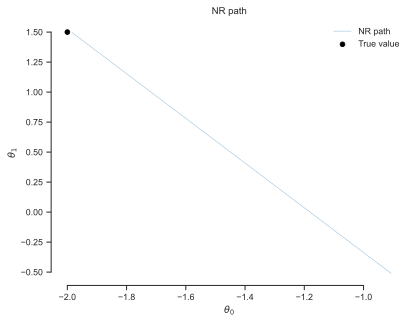

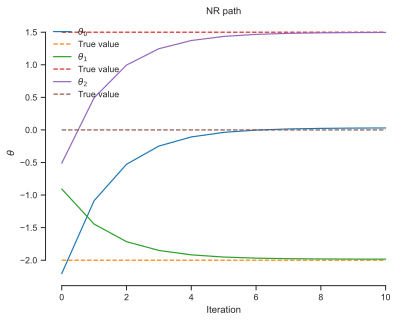

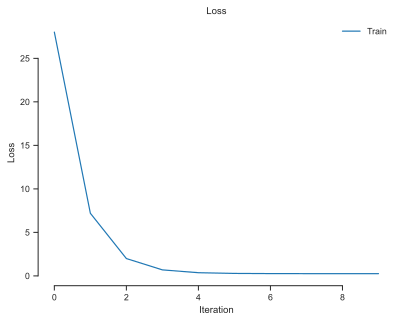

In [33]:
thetas = np.array(jax.tree_util.tree_leaves(path))

# 2D plot of the parameters evolution
fig, ax = plt.subplots()
ax.plot(thetas[:, 1], thetas[:, 2], alpha=0.5, lw=0.5, label="NR path")
# Correct values
ax.scatter([-2], [1.5], marker="o", color="black", label="True value")
ax.set(xlabel=r"$\theta_0$", ylabel=r"$\theta_1$", title="NR path")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

# Parameters per iteration
fig, ax = plt.subplots()
ax.plot(thetas[:, 0], label=r"$\theta_0$")
ax.plot([-2] * thetas.shape[0], '--', label="True value")
ax.plot(thetas[:, 1], label=r"$\theta_1$")
ax.plot([1.5] * thetas.shape[0], '--', label="True value")
ax.plot(thetas[:, 2], label=r"$\theta_2$")
ax.plot([0] * thetas.shape[0], '--', label="True value")
ax.set(xlabel="Iteration", ylabel=r"$\theta$", title="NR path")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

# The losses
fig, ax = plt.subplots()
ax.plot(losses, label="Train")
#ax.plot(losses, label="Test")
ax.set(xlabel="Iteration", ylabel="Loss", title="Loss")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

I hope that you can see that the algorithm is super fast.
As a matter of fact, in this particular example it converges in one iteration if you set the learning rate to 1. Why?

There is a catch though. The algorithm requires second derivatives of the objective function. In practice, it is not always possible to compute them. In addition, the Hessian matrix is $n \times n$ and it is not always possible to invert it. Inverting a matrix is a computationally expensive operation. Inverting a $n \times n$ matrix is $O(n^3)$, which is very expensive for large $n$. This is not going to work for large $n$ unless there Hessian turns out to be a sparse matrix. This is not the case when training neural networks.

## Broyden-Fletcher-Goldfarb-Shanno (BFGS) Method

The Broyden-Fletcher-Goldfarb-Shanno (BFGS) method is a quasi-Newton method. It is a second order method that does not require the Hessian matrix. Instead, it uses an approximation of the Hessian matrix. The approximation is updated at each iteration. The algorithm is as follows:

1. Initialize $x_0$ and $H_0$.
2. For $t=0,1,2,\ldots$:
    1. Compute the search direction $d_t = -H_t^{-1} \nabla f(x_t)$.
    2. Line search: find $\alpha_t$ such that $f(x_t + \alpha_t d_t) = \min_{\alpha \geq 0} f(x_t + \alpha d_t)$.
    3. Update $x_{t+1} = x_t + \alpha_t d_t$.
    4. Update $H_{t+1}$.

For the actual updates, see the [Wikipedia page](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm).

This is also not a good algorithm for training neural networks. This is because the matrix $H_t$ is also $n \times n$.
So, this is not a good algorithm for large $n$.

## Limited-memory BFGS (L-BFGS) Method

This version of the BFGS method does need $n \times n$ matrices. Instead, it uses a limited memory approximation of the Hessian matrix. You can find the exact updates here: [Wikipedia](https://en.wikipedia.org/wiki/Limited-memory_BFGS).
This is a good algorithm for training models in many cases.
When should you use it?

+ When you have a relatively small dataset so that each evaluation of the objective function is not too expensive. This is because the algorithm requires processing all the data at each iteration.
+ When you have some guarantees that the problem has a unique solution. This is because the algorithm is not guaranteed to converge to a global minimum. It is only guaranteed to converge to a local minimum.
+ If you don't have any uniqueness guarantees, then you can run the algorithm multiple times with different initializations and pick the best solution.

This algorithm is not implemented in `optax`. But you can find it in [jaxopt](https://jaxopt.github.io/stable/_autosummary/jaxopt.LBFGS.html).
Let's play with it.

In [35]:
import jaxopt

model = MyModel(subkey)

opt = jaxopt.LBFGS(loss, maxiter=10, jit=True)

n_iter = 20

opt_state = opt.init_state(model, X, y)

path = [model]
losses = [opt_state.value]

for i in range(n_iter):
    model, opt_state = opt.update(model, opt_state, X, y)
    path.append(model)
    losses.append(opt_state.value)


Here are the results:

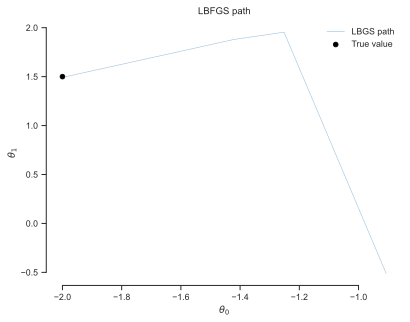

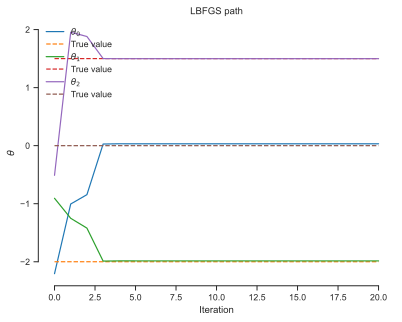

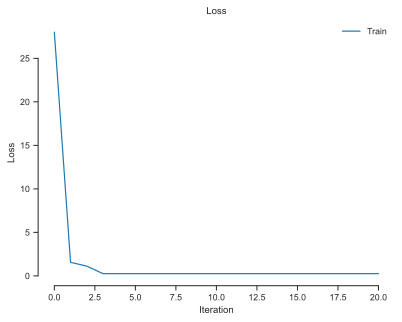

In [36]:
thetas = np.array(jax.tree_util.tree_leaves(path))

# 2D plot of the parameters evolution
fig, ax = plt.subplots()
ax.plot(thetas[:, 1], thetas[:, 2], alpha=0.5, lw=0.5, label="LBGS path")
# Correct values
ax.scatter([-2], [1.5], marker="o", color="black", label="True value")
ax.set(xlabel=r"$\theta_0$", ylabel=r"$\theta_1$", title="LBFGS path")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

# Parameters per iteration
fig, ax = plt.subplots()
ax.plot(thetas[:, 0], label=r"$\theta_0$")
ax.plot([-2] * thetas.shape[0], '--', label="True value")
ax.plot(thetas[:, 1], label=r"$\theta_1$")
ax.plot([1.5] * thetas.shape[0], '--', label="True value")
ax.plot(thetas[:, 2], label=r"$\theta_2$")
ax.plot([0] * thetas.shape[0], '--', label="True value")
ax.set(xlabel="Iteration", ylabel=r"$\theta$", title="LBFGS path")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

# The losses
fig, ax = plt.subplots()
ax.plot(losses, label="Train")
#ax.plot(losses, label="Test")
ax.set(xlabel="Iteration", ylabel="Loss", title="Loss")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Stochastic second-order methods

There are some stochastic second-order methods that can process the data in mini-batches, but they are not commonly used.
An example is [Stochastic L-BFGS-B](https://arxiv.org/abs/1703.00893).